# IMPORT STATEMENTS

In [1]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 graphviz

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
#from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.impute import SimpleImputer

2.1.0
2.2.4


Using TensorFlow backend.


# Load in Data, Prepare OHE, Prepare Main Data

In [3]:
#takes in a training testing csv and a holdout csv
#will extract final column and make that a label array for model training
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [ ]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("FlC_Merged_filtered.csv_train_test.csv_5pcnt.csv", "FlC_Merged_filtered.csv_holdout.csv_5pcnt.csv")

In [ ]:
#fits one hot encoder and transforms both training test data and holdout data in the same way
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

In [ ]:
#saves the onehot encoder for future use
pickle.dump(ohe, open("FC_ohe.dat", "wb"))

In [4]:
#if need or have new holdout data etc.
ohe = pickle.load(open("FC_ohe.dat", "rb"))

In [5]:
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [6]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 108005)
print(my_snp)

C/A


# XGBoost ML Model

### Importing the model building data, one hot encoding and creating a label set

In [ ]:
#for optimising the parameters, dont need to run if going straight to k-fold eval
print(vcf.shape)
print(pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(vcf, pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print(X_train.shape)
print("seed is " + str(seed))

# Setting Space to Optimise

In [ ]:

space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}

# Stops the optimising if above 98% accuracy

In [ ]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

# Look for optimium parameters from the defined space and print best params

In [ ]:
xgbcl = xgb.XGBClassifier()
xgb_bayes_search = BayesSearchCV(xgbcl, space, n_iter=32, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
xgb_bayes_search.best_params_

# Take Best Model from the Optimisation

In [ ]:
#either print out from the optimisation or run the ordered dict.

print(xgb_bayes_search.best_params_)
best_params = OrderedDict([('colsample_bylevel', 0.25617325301227906), ('colsample_bytree', 0.7083937150495909), ('gamma', 2.41812432168581e-07), ('learning_rate', 0.13965555720269418), ('max_delta_step', 10), ('max_depth', 27), ('min_child_weight', 1), ('n_estimators', 76), ('reg_alpha', 3.178148842971562e-08), ('reg_lambda', 0.005381781269387993), ('scale_pos_weight', 0.23835043249575294), ('subsample', 0.9559763235078597)])

In [ ]:
model = xgb.XGBClassifier(**xgb_bayes_search.best_params_)

# 10-fold cross validation on training / holdout data, evaluation and AUROC

# Creating Model from best parameters and then evaluating

In [4]:
def eval_k_fold(m, x, y, k, hx, hy):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    fig1 = plt.figure(figsize=[12,12])

    tprs = []
    aucs = []
    results = []
    mean_fpr = np.linspace(0,1,100)
    high = 0
    best = m
    i = 1
    for train,test in cv.split(x,y):
        prediction = m.fit(x[train],y[train].ravel()).predict_proba(x[test])
        print("variables for auroc curve done. Processing fold accuracy + checking best model")
        y_pred = m.predict(x[test])
        predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        accuracy = accuracy_score(y[test], predictions)
        pcent = accuracy * 100.0
        print("The accuracy of this model is" + str(pcent))
        if(pcent > high):
            high = pcent
            best = m
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        results.append(pcent)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
    
    holdout_pred = best.predict(hx)
    predictions = [round(value) for value in holdout_pred]
    #sees how accurate the model was when testing the test set
    accuracy = accuracy_score(hy, predictions)
    pcent = accuracy * 100.0
    print(pcent)
    xgb_predictions = best.predict(hx)
    xgb_probs = best.predict_proba(hx)[:, 1]
    model_fpr, model_tpr, my_roccy = evaluate_model(xgb_predictions, xgb_probs, hy)
    plt.plot(model_fpr, model_tpr, 'r', label = 'Holdout Data'+my_roccy, lw=2)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Flower Colour Training Model & Holdout Data')
    plt.legend(loc="lower right")
    plt.show()

    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    print("Holdout Accuracy: %.2f%%" % (pcent))
    
    return best

In [ ]:
#THESE ARE THE BEST PARAMETERS
best_params = OrderedDict([('colsample_bylevel', 0.25617325301227906), ('colsample_bytree', 0.7083937150495909), ('gamma', 2.41812432168581e-07), ('learning_rate', 0.13965555720269418), ('max_delta_step', 10), ('max_depth', 27), ('min_child_weight', 1), ('n_estimators', 76), ('reg_alpha', 3.178148842971562e-08), ('reg_lambda', 0.005381781269387993), ('scale_pos_weight', 0.23835043249575294), ('subsample', 0.9559763235078597)])
#load holdout data
print(tt_vcf.shape)
print(tt_pheno.shape)
print(ho_vcf.shape)
print(ho_pheno.shape)
model_2 = xgb.XGBClassifier(**best_params) #if optimised in same session, other enter manually below
#this function should average out 10 folds and training, with inital params optimised
#average accuracy and std should be calculated along with a nice AUROC graph of train/test models
#best model should be extracted for use on holdout set
best_model = eval_k_fold(model_2, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)


# save this model

In [ ]:
import pickle
pickle.dump(best_model, open("FC_kfold_10_tt_from_all.pickle.dat", "wb"))

# load model

In [7]:
#only load if not generated in same session
best_model = pickle.load(open("FC_kfold_10_tt_from_all.pickle.dat", "rb"))

# SNPS of Importance

<Figure size 1440x1440 with 0 Axes>

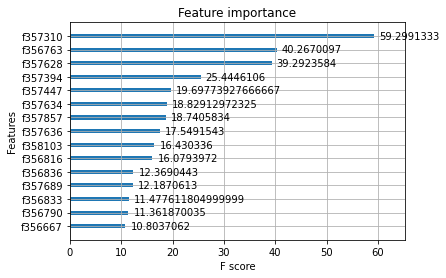

In [8]:
from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("FC_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

In [9]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("FlC_Merged_filtered.csv_train_test.csv_5pcnt.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

my X value is: 28520
(620, 28520)
my header list is: 28520
my X value is: 57352
(620, 28832)
my header list is: 57352
my X value is: 86366
(620, 29014)
my header list is: 86366
my X value is: 115595
(620, 29229)
my header list is: 115595
my X value is: 144390
(620, 28795)
my header list is: 144390
my X value is: 173592
(620, 29202)
my header list is: 173592
my X value is: 202769
(620, 29177)
my header list is: 202769
my X value is: 231723
(620, 28954)
my header list is: 231723
my X value is: 260540
(620, 28817)
my header list is: 260540
my X value is: 289382
(620, 28842)
my header list is: 289382
my X value is: 318374
(620, 28992)
my header list is: 318374
my X value is: 347265
(620, 28891)
my header list is: 347265
my X value is: 376458
(620, 29193)
my header list is: 376458
my X value is: 405326
(620, 28868)
my header list is: 405326
my X value is: 434699
(620, 29373)
my header list is: 434699
my X value is: 463771
(620, 29072)
my header list is: 463771
my X value is: 492924
(620, 29

In [11]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [12]:
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [13]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [14]:
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})
print(df)

Gm13_18100168 (C/C)    18.829130
Gm13_16679437 (A/A)    40.267010
Gm04_19777486 (A/A)     3.634090
Gm01_6628055 (A/T)      0.350054
Gm06_14184633 (G/G)     4.900682
                         ...    
Gm18_5306444 (T/T)      0.325163
Gm01_53035662 (A/A)     0.337171
Gm18_59436007 (T/T)     0.325363
Gm13_14444566 (A/A)     0.318347
Gm04_8701979 (C/C)      0.270724
Length: 281, dtype: float64
                     F_Score(GAIN)
Gm13_18100168 (C/C)      18.829130
Gm13_16679437 (A/A)      40.267010
Gm04_19777486 (A/A)       3.634090
Gm01_6628055 (A/T)        0.350054
Gm06_14184633 (G/G)       4.900682
...                            ...
Gm18_5306444 (T/T)        0.325163
Gm01_53035662 (A/A)       0.337171
Gm18_59436007 (T/T)       0.325363
Gm13_14444566 (A/A)       0.318347
Gm04_8701979 (C/C)        0.270724

[281 rows x 1 columns]


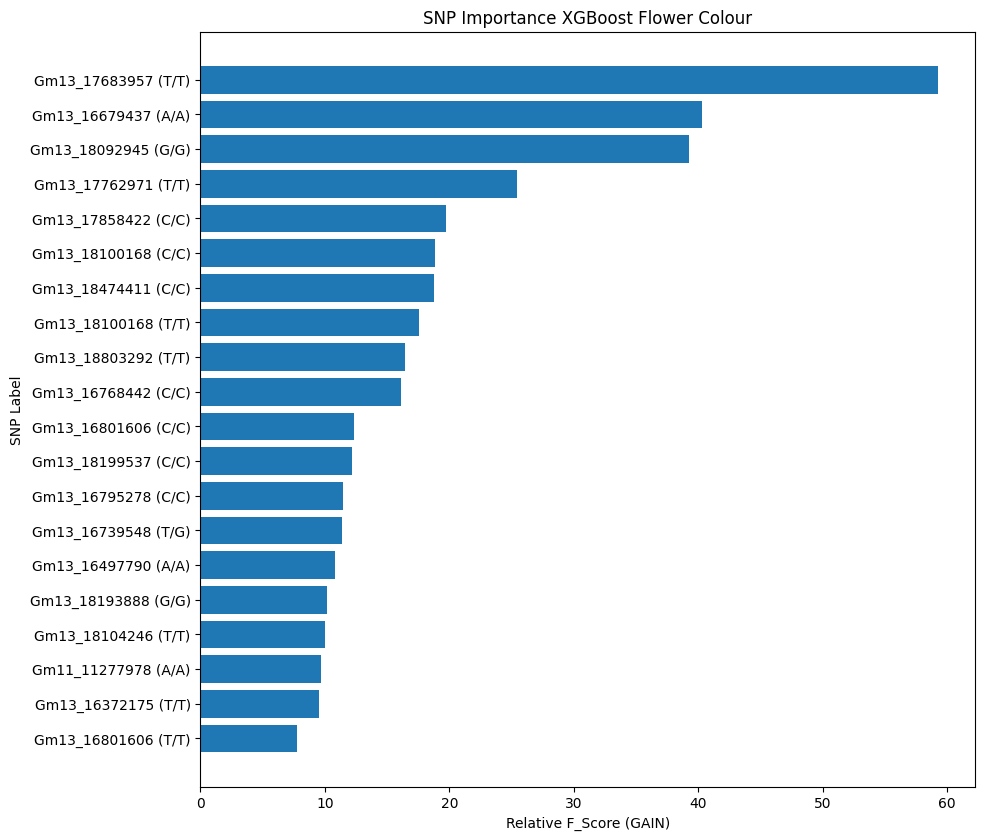

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Flower Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

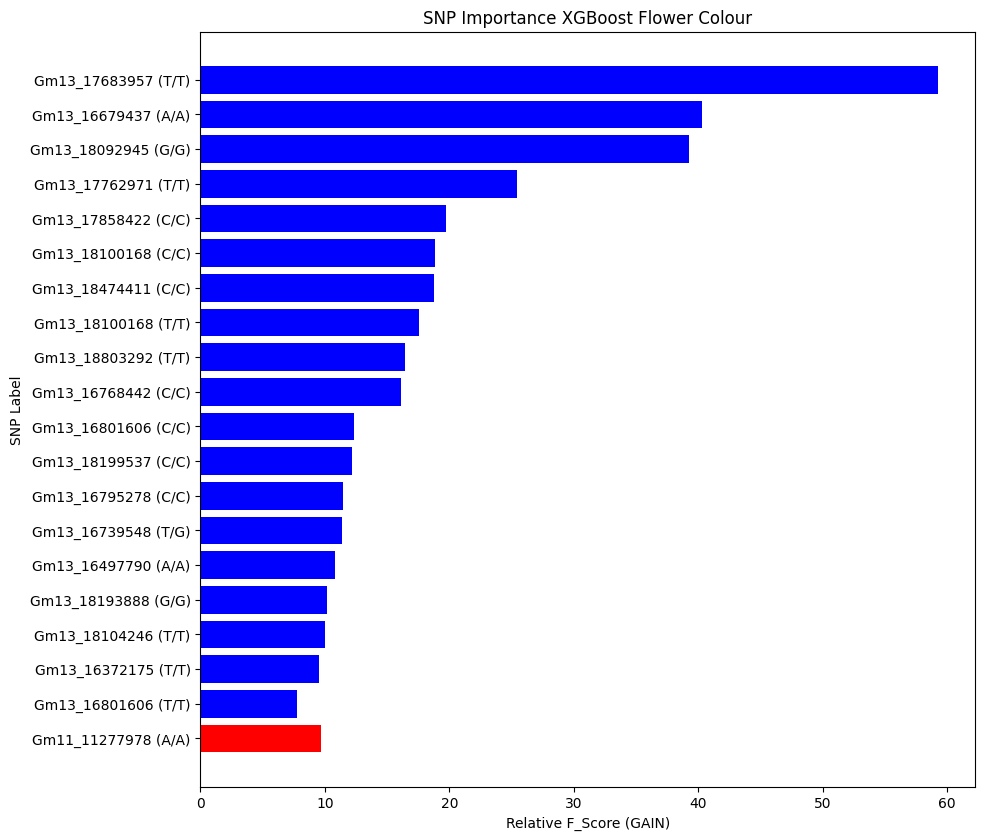

In [18]:
#generate figure object
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#load in the 20 lardest values and their SNP label
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
#reverse to make the largest be at the front
indexes = indexes[::-1]
values = values[::-1]
#for each different chromosome you want to colour add a index(*_i) and value (*_v) array
#black would be colour for singular/notinteresting chromosomes
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
br_i = []
br_v = []
pu_i = []
pu_v = []
#for each value in the top n (default 20) check which chromosome it belongs to and add it to the colour array
i = 0
while i < len(indexes):
    if('Gm11' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm13' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
  #  elif('Gm01' in indexes[i]):
   #     g_i.append(indexes[i])
    #    g_v.append(values[i])
    #elif('Gm11' in indexes[i]):
    #    y_i.append(indexes[i])
    #    y_v.append(values[i])
    #elif('Gm08' in indexes[i]):
    #    p_i.append(indexes[i])
    #    p_v.append(values[i])
   # elif('Gm04' in indexes[i]):
   #     br_i.append(indexes[i])
   #     br_v.append(values[i])
   # elif('Gm13' in indexes[i]):
   #     pu_i.append(indexes[i])
   #     pu_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
#plot each of the arrays with appropriate colour and label graph
plt.barh(bl_i, bl_v, color="black")
plt.barh(br_i, br_v, color="brown")
plt.barh(pu_i, pu_v, color="purple")
plt.barh(y_i, y_v, color="yellow")
plt.barh(p_i, p_v, color="orange")
plt.barh(g_i, g_v, color="green")
plt.barh(r_i, r_v, color="red")
plt.barh(b_i, b_v, color="blue")
plt.title('SNP Importance XGBoost Flower Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# Random Forest ML Model

In [ ]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('FlC_Merged_filtered.csv_train_test.csv_5pcnt.csv', 'FlC_Merged_filtered.csv_holdout.csv_5pcnt.csv')

In [ ]:
ohe = pickle.load(open("FC_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

In [ ]:
seed = randint(0,5000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed, max_features = 'sqrt',n_jobs=-1, verbose = 1)
best_rf_model = eval_k_fold(rf_model, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)

# CNN Model (based upon DL Primer)
### one hot encode and train test split like you usually do but follow the primer for the actual model part
### for BC and MC use primer, for regression use Philipps notebooks....

In [5]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('FlC_Merged_filtered.csv_train_test.csv_5pcnt.csv', 'FlC_Merged_filtered.csv_holdout.csv_5pcnt.csv')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(620,)
(620, 1)
220000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(156,)
(156, 1)
220000
(620, 214792)
(156, 214792)


In [6]:
ohe = pickle.load(open("FC_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(620, 622888)
(156, 214792)
(156, 622888)


In [7]:
def build_CNN_model(x_len):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=14, 
                     input_shape=(x_len, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(12, 1)))
    model.add(Activation('linear'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(16, 1)))
    model.add(Activation('linear'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(48, activation='linear'))
    model.add(Dense(32, activation='linear'))
    model.add(Dense(16, activation='linear'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"


    model.compile(loss='binary_crossentropy', optimizer=opt, 
                  metrics=['binary_accuracy'])

    print(model.summary())
    return model

In [8]:
def eval_cnn(x,y,k):
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        x = x.reshape(x.shape[0], x.shape[1], 1)
        model = build_CNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/40)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy *100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        del model
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [9]:
best_CNN = eval_cnn(tt_vcf, tt_pheno, 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 622875, 12)        180       
_________________________________________________________________
activation (Activation)      (None, 622875, 12)        0         
_________________________________________________________________
dropout (Dropout)            (None, 622875, 12)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 622866, 10)        1210      
_________________________________________________________________
activation_1 (Activation)    (None, 622866, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 622866, 10)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 622859, 8)         6

Epoch 87/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0329 - binary_accuracy: 0.9892 - val_loss: 0.9332 - val_binary_accuracy: 0.8095
Epoch 88/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0203 - binary_accuracy: 0.9892 - val_loss: 1.1560 - val_binary_accuracy: 0.7619
Epoch 89/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0145 - binary_accuracy: 0.9964 - val_loss: 0.8626 - val_binary_accuracy: 0.7460
Epoch 90/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0351 - binary_accuracy: 0.9928 - val_loss: 1.8695 - val_binary_accuracy: 0.7143
Epoch 91/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0111 - binary_accuracy: 0.9964 - val_loss: 2.0386 - val_binary_accuracy: 0.6190
Epoch 92/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0060 - binary_accuracy: 1.0000 - val_loss: 1.3650 - val_binary_accuracy: 0.6508
Epoch 93/100
557/557 [============

Epoch 22/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0283 - binary_accuracy: 0.9874 - val_loss: 0.5237 - val_binary_accuracy: 0.7302
Epoch 23/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0708 - binary_accuracy: 0.9731 - val_loss: 0.5652 - val_binary_accuracy: 0.7937
Epoch 24/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0396 - binary_accuracy: 0.9928 - val_loss: 0.6058 - val_binary_accuracy: 0.7778
Epoch 25/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0215 - binary_accuracy: 0.9964 - val_loss: 0.9482 - val_binary_accuracy: 0.6667
Epoch 26/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0148 - binary_accuracy: 1.0000 - val_loss: 0.4474 - val_binary_accuracy: 0.8095
Epoch 27/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0116 - binary_accuracy: 1.0000 - val_loss: 0.4422 - val_binary_accuracy: 0.7460
Epoch 28/100
557/557 [============

Epoch 73/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0034 - binary_accuracy: 1.0000 - val_loss: 0.3912 - val_binary_accuracy: 0.8095
Epoch 74/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0043 - binary_accuracy: 1.0000 - val_loss: 0.4662 - val_binary_accuracy: 0.7937
Epoch 75/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0031 - binary_accuracy: 1.0000 - val_loss: 0.4734 - val_binary_accuracy: 0.8254
Epoch 76/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0018 - binary_accuracy: 1.0000 - val_loss: 0.4685 - val_binary_accuracy: 0.8254
Epoch 77/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0045 - binary_accuracy: 1.0000 - val_loss: 0.3990 - val_binary_accuracy: 0.8254
Epoch 78/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0159 - binary_accuracy: 0.9982 - val_loss: 1.2896 - val_binary_accuracy: 0.6825
Epoch 79/100
557/557 [============

Epoch 8/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0389 - binary_accuracy: 0.9964 - val_loss: 0.5468 - val_binary_accuracy: 0.6825
Epoch 9/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0340 - binary_accuracy: 0.9982 - val_loss: 0.7304 - val_binary_accuracy: 0.6984
Epoch 10/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0375 - binary_accuracy: 0.9946 - val_loss: 0.4610 - val_binary_accuracy: 0.7937
Epoch 11/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0336 - binary_accuracy: 0.9946 - val_loss: 0.4375 - val_binary_accuracy: 0.8254
Epoch 12/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0201 - binary_accuracy: 1.0000 - val_loss: 0.2608 - val_binary_accuracy: 0.9048
Epoch 13/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0256 - binary_accuracy: 0.9982 - val_loss: 0.4265 - val_binary_accuracy: 0.8254
Epoch 14/100
557/557 [==============

Epoch 59/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0064 - binary_accuracy: 1.0000 - val_loss: 0.5290 - val_binary_accuracy: 0.8889
Epoch 60/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0065 - binary_accuracy: 1.0000 - val_loss: 0.2778 - val_binary_accuracy: 0.9365
Epoch 61/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0182 - binary_accuracy: 0.9946 - val_loss: 0.8401 - val_binary_accuracy: 0.7937
Epoch 62/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0182 - binary_accuracy: 0.9946 - val_loss: 1.0085 - val_binary_accuracy: 0.7937
Epoch 63/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0200 - binary_accuracy: 0.9946 - val_loss: 0.0987 - val_binary_accuracy: 0.9841
Epoch 64/100
557/557 [==============================] - 7s 12ms/sample - loss: 0.0632 - binary_accuracy: 0.9785 - val_loss: 0.3957 - val_binary_accuracy: 0.8889
Epoch 65/100
557/557 [============

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 14s 25ms/sample - loss: 0.7392 - binary_accuracy: 0.6380 - val_loss: 0.6739 - val_binary_accuracy: 0.5645
Epoch 2/100
558/558 [==============================] - 7s 13ms/sample - loss: 0.5831 - binary_accuracy: 0.6828 - val_loss: 0.6410 - val_binary_accuracy: 0.5806
Epoch 3/100
558/558 [==============================] - 7s 13ms/sample - loss: 0.5283 - binary_accuracy: 0.7330 - val_loss: 0.6332 - val_binary_accuracy: 0.6129
Epoch 4/100
558/558 [==============================] - 7s 13ms/sample - loss: 0.3845 - binary_accuracy: 0.8441 - val_loss: 0.6632 - val_binary_accuracy: 0.6129
Epoch 5/100
558/558 [==============================] - 7s 13ms/sample - loss: 0.2039 - binary_accuracy: 0.9516 - val_loss: 0.6016 - val_binary_accuracy: 0.6129
Epoch 6/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.1302 - binary_accuracy: 0.9552 - val_loss: 0.5525 - val_binary_accuracy: 0

Epoch 52/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0211 - binary_accuracy: 0.9946 - val_loss: 0.6583 - val_binary_accuracy: 0.7903
Epoch 53/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0071 - binary_accuracy: 1.0000 - val_loss: 0.5672 - val_binary_accuracy: 0.8710
Epoch 54/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0162 - binary_accuracy: 0.9964 - val_loss: 0.5711 - val_binary_accuracy: 0.7742
Epoch 55/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0045 - binary_accuracy: 1.0000 - val_loss: 0.4369 - val_binary_accuracy: 0.8226
Epoch 56/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0096 - binary_accuracy: 1.0000 - val_loss: 0.5111 - val_binary_accuracy: 0.8226
Epoch 57/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0375 - binary_accuracy: 0.9857 - val_loss: 0.9475 - val_binary_accuracy: 0.6613
Epoch 58/100
558/558 [============

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 15s 26ms/sample - loss: 0.7200 - binary_accuracy: 0.6075 - val_loss: 0.6465 - val_binary_accuracy: 0.6129
Epoch 2/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.5840 - binary_accuracy: 0.6685 - val_loss: 0.6916 - val_binary_accuracy: 0.6129
Epoch 3/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.5276 - binary_accuracy: 0.7186 - val_loss: 0.7727 - val_binary_accuracy: 0.6129
Epoch 4/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.3615 - binary_accuracy: 0.8584 - val_loss: 0.8160 - val_binary_accuracy: 0.6129
Epoch 5/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.1836 - binary_accuracy: 0.9534 - val_loss: 0.7031 - val_binary_accuracy: 0.6129
Epoch 6/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.1010 - binary_accuracy: 0.9767 - val_loss: 0.6966 - val_binary_accuracy: 0

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 12s 21ms/sample - loss: 0.8499 - binary_accuracy: 0.6093 - val_loss: 0.6750 - val_binary_accuracy: 0.5484
Epoch 2/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.5988 - binary_accuracy: 0.6631 - val_loss: 0.6395 - val_binary_accuracy: 0.6129
Epoch 3/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.5415 - binary_accuracy: 0.7133 - val_loss: 0.6279 - val_binary_accuracy: 0.6129
Epoch 4/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.3938 - binary_accuracy: 0.8441 - val_loss: 0.6819 - val_binary_accuracy: 0.6129
Epoch 5/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.1687 - binary_accuracy: 0.9498 - val_loss: 0.6130 - val_binary_accuracy: 0.6129
Epoch 6/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.1149 - binary_accuracy: 0.9785 - val_loss: 0.4693 - val_binary_accuracy: 0

Epoch 52/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0029 - binary_accuracy: 1.0000 - val_loss: 0.2487 - val_binary_accuracy: 0.9032
Epoch 53/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0191 - binary_accuracy: 0.9946 - val_loss: 0.3807 - val_binary_accuracy: 0.8710
Epoch 54/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0420 - binary_accuracy: 0.9892 - val_loss: 1.9023 - val_binary_accuracy: 0.6774
Epoch 55/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0286 - binary_accuracy: 0.9892 - val_loss: 0.3034 - val_binary_accuracy: 0.8548
Epoch 56/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0067 - binary_accuracy: 1.0000 - val_loss: 0.2606 - val_binary_accuracy: 0.8387
Epoch 57/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.0063 - binary_accuracy: 1.0000 - val_loss: 0.2729 - val_binary_accuracy: 0.8548
Epoch 58/100
558/558 [============

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 10s 19ms/sample - loss: 0.7569 - binary_accuracy: 0.5663 - val_loss: 0.6748 - val_binary_accuracy: 0.5323
Epoch 2/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.5786 - binary_accuracy: 0.6846 - val_loss: 0.6565 - val_binary_accuracy: 0.6129
Epoch 3/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.5209 - binary_accuracy: 0.7527 - val_loss: 0.7513 - val_binary_accuracy: 0.6129
Epoch 4/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.3350 - binary_accuracy: 0.8548 - val_loss: 0.7505 - val_binary_accuracy: 0.6129
Epoch 5/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.1747 - binary_accuracy: 0.9498 - val_loss: 0.7103 - val_binary_accuracy: 0.6129
Epoch 6/100
558/558 [==============================] - 7s 12ms/sample - loss: 0.1013 - binary_accuracy: 0.9767 - val_loss: 0.6688 - val_binary_accuracy: 0

Train on 559 samples, validate on 61 samples
Epoch 1/100
559/559 [==============================] - 13s 22ms/sample - loss: 0.6502 - binary_accuracy: 0.6315 - val_loss: 0.6594 - val_binary_accuracy: 0.6230
Epoch 2/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.5580 - binary_accuracy: 0.7013 - val_loss: 0.6981 - val_binary_accuracy: 0.6230
Epoch 3/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.4743 - binary_accuracy: 0.8140 - val_loss: 0.7290 - val_binary_accuracy: 0.6230
Epoch 4/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.3270 - binary_accuracy: 0.9070 - val_loss: 0.6830 - val_binary_accuracy: 0.6230
Epoch 5/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.1788 - binary_accuracy: 0.9499 - val_loss: 0.6554 - val_binary_accuracy: 0.6230
Epoch 6/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.1267 - binary_accuracy: 0.9732 - val_loss: 0.6176 - val_binary_accuracy: 0

Train on 559 samples, validate on 61 samples
Epoch 1/100
559/559 [==============================] - 12s 22ms/sample - loss: 0.6704 - binary_accuracy: 0.5939 - val_loss: 0.6964 - val_binary_accuracy: 0.6230
Epoch 2/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.5881 - binary_accuracy: 0.6547 - val_loss: 0.6704 - val_binary_accuracy: 0.6230
Epoch 3/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.5293 - binary_accuracy: 0.7299 - val_loss: 0.6664 - val_binary_accuracy: 0.6230
Epoch 4/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.4092 - binary_accuracy: 0.8336 - val_loss: 0.7853 - val_binary_accuracy: 0.6230
Epoch 5/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.2114 - binary_accuracy: 0.9284 - val_loss: 0.6822 - val_binary_accuracy: 0.6230
Epoch 6/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.1152 - binary_accuracy: 0.9642 - val_loss: 0.4981 - val_binary_accuracy: 0

Train on 559 samples, validate on 61 samples
Epoch 1/100
559/559 [==============================] - 21s 37ms/sample - loss: 0.7157 - binary_accuracy: 0.6172 - val_loss: 0.6318 - val_binary_accuracy: 0.6230
Epoch 2/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.5426 - binary_accuracy: 0.7370 - val_loss: 0.6266 - val_binary_accuracy: 0.6230
Epoch 3/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.4620 - binary_accuracy: 0.7835 - val_loss: 0.6468 - val_binary_accuracy: 0.6230
Epoch 4/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.2914 - binary_accuracy: 0.9088 - val_loss: 0.6735 - val_binary_accuracy: 0.6230
Epoch 5/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.1652 - binary_accuracy: 0.9445 - val_loss: 0.6569 - val_binary_accuracy: 0.6230
Epoch 6/100
559/559 [==============================] - 7s 12ms/sample - loss: 0.1228 - binary_accuracy: 0.9589 - val_loss: 0.5315 - val_binary_accuracy: 0

In [10]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1],1)
_, accuracy = best_CNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 87.82051205635071


# DNN Model

In [6]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('FlC_Merged_filtered.csv_train_test.csv_5pcnt.csv', 'FlC_Merged_filtered.csv_holdout.csv_5pcnt.csv')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(620,)
(620, 1)
220000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(156,)
(156, 1)
220000
(620, 214792)
(156, 214792)


In [7]:
ohe = pickle.load(open("FC_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(620, 622888)
(156, 214792)
(156, 622888)


In [14]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(256, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
    print(model.summary())
    return model



In [15]:
def eval_dnn(x,y,k): 
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        model = build_DNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/40)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs = 100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy * 100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [16]:
best_DNN = eval_dnn(tt_vcf, tt_pheno, 10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               159459584 
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

557/557 [==============================] - 2s 4ms/sample - loss: 0.0196 - binary_accuracy: 0.9928 - val_loss: 1.1216 - val_binary_accuracy: 0.7937
Epoch 89/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0154 - binary_accuracy: 0.9982 - val_loss: 1.1307 - val_binary_accuracy: 0.7778
Epoch 90/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0030 - binary_accuracy: 0.9982 - val_loss: 1.3244 - val_binary_accuracy: 0.6984
Epoch 91/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0071 - binary_accuracy: 0.9982 - val_loss: 2.6394 - val_binary_accuracy: 0.6508
Epoch 92/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0077 - binary_accuracy: 0.9946 - val_loss: 1.3664 - val_binary_accuracy: 0.6984
Epoch 93/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0214 - binary_accuracy: 0.9964 - val_loss: 2.7018 - val_binary_accuracy: 0.6508
Epoch 94/100
557/557 [==============================]

557/557 [==============================] - 2s 4ms/sample - loss: 0.0330 - binary_accuracy: 0.9838 - val_loss: 1.3782 - val_binary_accuracy: 0.7302
Epoch 25/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0116 - binary_accuracy: 0.9964 - val_loss: 0.8281 - val_binary_accuracy: 0.7302
Epoch 26/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0080 - binary_accuracy: 0.9982 - val_loss: 1.2550 - val_binary_accuracy: 0.6984
Epoch 27/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0158 - binary_accuracy: 0.9946 - val_loss: 0.9575 - val_binary_accuracy: 0.8095
Epoch 28/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0522 - binary_accuracy: 0.9874 - val_loss: 0.5385 - val_binary_accuracy: 0.7302
Epoch 29/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0066 - binary_accuracy: 1.0000 - val_loss: 0.6715 - val_binary_accuracy: 0.7302
Epoch 30/100
557/557 [==============================]

557/557 [==============================] - 2s 4ms/sample - loss: 0.1053 - binary_accuracy: 0.9641 - val_loss: 0.3807 - val_binary_accuracy: 0.8413
Epoch 12/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0582 - binary_accuracy: 0.9820 - val_loss: 0.5105 - val_binary_accuracy: 0.8413
Epoch 13/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0420 - binary_accuracy: 0.9892 - val_loss: 0.4505 - val_binary_accuracy: 0.8413
Epoch 14/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0422 - binary_accuracy: 0.9838 - val_loss: 0.3830 - val_binary_accuracy: 0.8571
Epoch 15/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0618 - binary_accuracy: 0.9767 - val_loss: 0.4690 - val_binary_accuracy: 0.8413
Epoch 16/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.0850 - binary_accuracy: 0.9659 - val_loss: 0.4418 - val_binary_accuracy: 0.8254
Epoch 17/100
557/557 [==============================]

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 12s 21ms/sample - loss: 0.6685 - binary_accuracy: 0.6165 - val_loss: 1.7864 - val_binary_accuracy: 0.6129
Epoch 2/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.6338 - binary_accuracy: 0.6380 - val_loss: 1.3914 - val_binary_accuracy: 0.6129
Epoch 3/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.5967 - binary_accuracy: 0.6989 - val_loss: 0.5738 - val_binary_accuracy: 0.6613
Epoch 4/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.5067 - binary_accuracy: 0.7634 - val_loss: 0.5646 - val_binary_accuracy: 0.6774
Epoch 5/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.4388 - binary_accuracy: 0.7903 - val_loss: 1.2784 - val_binary_accuracy: 0.5968
Epoch 6/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.3462 - binary_accuracy: 0.8548 - val_loss: 0.6738 - val_binary_accuracy: 0.7258

Epoch 52/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0181 - binary_accuracy: 0.9910 - val_loss: 0.7634 - val_binary_accuracy: 0.7903
Epoch 53/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0064 - binary_accuracy: 0.9964 - val_loss: 0.7704 - val_binary_accuracy: 0.8065
Epoch 54/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0036 - binary_accuracy: 1.0000 - val_loss: 0.8406 - val_binary_accuracy: 0.7903
Epoch 55/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0139 - binary_accuracy: 0.9982 - val_loss: 0.9225 - val_binary_accuracy: 0.7903
Epoch 56/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0126 - binary_accuracy: 0.9982 - val_loss: 0.8417 - val_binary_accuracy: 0.8065
Epoch 57/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0025 - binary_accuracy: 1.0000 - val_loss: 0.9178 - val_binary_accuracy: 0.7903
Epoch 58/100
558/558 [==================

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 11s 19ms/sample - loss: 0.6736 - binary_accuracy: 0.5878 - val_loss: 1.2826 - val_binary_accuracy: 0.6129
Epoch 2/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.6010 - binary_accuracy: 0.6595 - val_loss: 1.7099 - val_binary_accuracy: 0.6129
Epoch 3/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.4975 - binary_accuracy: 0.7616 - val_loss: 0.5176 - val_binary_accuracy: 0.7419
Epoch 4/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.4262 - binary_accuracy: 0.8136 - val_loss: 0.7711 - val_binary_accuracy: 0.6452
Epoch 5/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.3133 - binary_accuracy: 0.8763 - val_loss: 0.5900 - val_binary_accuracy: 0.7419
Epoch 6/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.2043 - binary_accuracy: 0.9319 - val_loss: 0.5195 - val_binary_accuracy: 0.7742

Epoch 52/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0461 - binary_accuracy: 0.9803 - val_loss: 1.1636 - val_binary_accuracy: 0.6935
Epoch 53/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0188 - binary_accuracy: 0.9982 - val_loss: 0.8149 - val_binary_accuracy: 0.7419
Epoch 54/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0223 - binary_accuracy: 0.9928 - val_loss: 0.8156 - val_binary_accuracy: 0.7419
Epoch 55/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0164 - binary_accuracy: 0.9964 - val_loss: 0.6870 - val_binary_accuracy: 0.8387
Epoch 56/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0537 - binary_accuracy: 0.9803 - val_loss: 7.6427 - val_binary_accuracy: 0.3871
Epoch 57/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0379 - binary_accuracy: 0.9892 - val_loss: 3.6333 - val_binary_accuracy: 0.4032
Epoch 58/100
558/558 [==================

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 12s 22ms/sample - loss: 0.6722 - binary_accuracy: 0.6039 - val_loss: 0.6070 - val_binary_accuracy: 0.6290
Epoch 2/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.5969 - binary_accuracy: 0.6380 - val_loss: 0.7296 - val_binary_accuracy: 0.6129
Epoch 3/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.5533 - binary_accuracy: 0.6971 - val_loss: 0.6596 - val_binary_accuracy: 0.6129
Epoch 4/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.4882 - binary_accuracy: 0.7437 - val_loss: 0.6692 - val_binary_accuracy: 0.6613
Epoch 5/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.4328 - binary_accuracy: 0.7903 - val_loss: 0.5891 - val_binary_accuracy: 0.6613
Epoch 6/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.3153 - binary_accuracy: 0.8728 - val_loss: 0.5331 - val_binary_accuracy: 0.7258

Epoch 52/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0047 - binary_accuracy: 0.9982 - val_loss: 0.5231 - val_binary_accuracy: 0.9032
Epoch 53/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0026 - binary_accuracy: 0.9982 - val_loss: 1.0161 - val_binary_accuracy: 0.7903
Epoch 54/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0176 - binary_accuracy: 0.9964 - val_loss: 1.7203 - val_binary_accuracy: 0.7419
Epoch 55/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0163 - binary_accuracy: 0.9946 - val_loss: 0.5940 - val_binary_accuracy: 0.8548
Epoch 56/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0061 - binary_accuracy: 0.9982 - val_loss: 0.3264 - val_binary_accuracy: 0.9032
Epoch 57/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0160 - binary_accuracy: 0.9964 - val_loss: 0.4897 - val_binary_accuracy: 0.8871
Epoch 58/100
558/558 [==================

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 11s 19ms/sample - loss: 0.6903 - binary_accuracy: 0.5376 - val_loss: 1.3835 - val_binary_accuracy: 0.3871
Epoch 2/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.6100 - binary_accuracy: 0.6470 - val_loss: 0.8583 - val_binary_accuracy: 0.4516
Epoch 3/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.5582 - binary_accuracy: 0.7025 - val_loss: 0.6299 - val_binary_accuracy: 0.5968
Epoch 4/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.4460 - binary_accuracy: 0.8082 - val_loss: 0.6698 - val_binary_accuracy: 0.6129
Epoch 5/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.3490 - binary_accuracy: 0.8602 - val_loss: 0.7279 - val_binary_accuracy: 0.5645
Epoch 6/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.2506 - binary_accuracy: 0.9122 - val_loss: 1.2882 - val_binary_accuracy: 0.6452

Epoch 52/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0023 - binary_accuracy: 1.0000 - val_loss: 0.8898 - val_binary_accuracy: 0.7581
Epoch 53/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0137 - binary_accuracy: 0.9946 - val_loss: 1.2697 - val_binary_accuracy: 0.7097
Epoch 54/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0071 - binary_accuracy: 0.9964 - val_loss: 1.1415 - val_binary_accuracy: 0.7258
Epoch 55/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0090 - binary_accuracy: 0.9982 - val_loss: 1.5145 - val_binary_accuracy: 0.7258
Epoch 56/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0226 - binary_accuracy: 0.9928 - val_loss: 1.6268 - val_binary_accuracy: 0.6774
Epoch 57/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.0068 - binary_accuracy: 0.9982 - val_loss: 2.6496 - val_binary_accuracy: 0.6613
Epoch 58/100
558/558 [==================

Train on 559 samples, validate on 61 samples
Epoch 1/100
559/559 [==============================] - 16s 30ms/sample - loss: 0.6581 - binary_accuracy: 0.5903 - val_loss: 2.1781 - val_binary_accuracy: 0.6230
Epoch 2/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.6080 - binary_accuracy: 0.6315 - val_loss: 0.9354 - val_binary_accuracy: 0.6230
Epoch 3/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.5641 - binary_accuracy: 0.7156 - val_loss: 1.0062 - val_binary_accuracy: 0.6230
Epoch 4/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.4986 - binary_accuracy: 0.7585 - val_loss: 1.3097 - val_binary_accuracy: 0.6230
Epoch 5/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.4561 - binary_accuracy: 0.7692 - val_loss: 0.6524 - val_binary_accuracy: 0.6393
Epoch 6/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.3804 - binary_accuracy: 0.8569 - val_loss: 0.7505 - val_binary_accuracy: 0.5738

Epoch 52/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0571 - binary_accuracy: 0.9803 - val_loss: 2.7041 - val_binary_accuracy: 0.4262
Epoch 53/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0089 - binary_accuracy: 0.9964 - val_loss: 1.5572 - val_binary_accuracy: 0.5738
Epoch 54/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0065 - binary_accuracy: 0.9964 - val_loss: 1.4785 - val_binary_accuracy: 0.6066
Epoch 55/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0041 - binary_accuracy: 0.9982 - val_loss: 0.9706 - val_binary_accuracy: 0.7705
Epoch 56/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0057 - binary_accuracy: 0.9982 - val_loss: 1.0800 - val_binary_accuracy: 0.7377
Epoch 57/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0054 - binary_accuracy: 0.9982 - val_loss: 1.1478 - val_binary_accuracy: 0.7213
Epoch 58/100
559/559 [==================

Train on 559 samples, validate on 61 samples
Epoch 1/100
559/559 [==============================] - 18s 33ms/sample - loss: 0.6345 - binary_accuracy: 0.6243 - val_loss: 1.3246 - val_binary_accuracy: 0.6230
Epoch 2/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.5748 - binary_accuracy: 0.6476 - val_loss: 0.7525 - val_binary_accuracy: 0.6230
Epoch 3/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.4921 - binary_accuracy: 0.7531 - val_loss: 0.5467 - val_binary_accuracy: 0.6721
Epoch 4/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.4378 - binary_accuracy: 0.7979 - val_loss: 1.6143 - val_binary_accuracy: 0.6230
Epoch 5/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.3889 - binary_accuracy: 0.8515 - val_loss: 1.8666 - val_binary_accuracy: 0.6230
Epoch 6/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.2578 - binary_accuracy: 0.9141 - val_loss: 0.3561 - val_binary_accuracy: 0.8689

Epoch 52/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0043 - binary_accuracy: 1.0000 - val_loss: 0.3911 - val_binary_accuracy: 0.8689
Epoch 53/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0060 - binary_accuracy: 1.0000 - val_loss: 0.3147 - val_binary_accuracy: 0.9016
Epoch 54/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0030 - binary_accuracy: 1.0000 - val_loss: 0.7344 - val_binary_accuracy: 0.8197
Epoch 55/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0229 - binary_accuracy: 0.9946 - val_loss: 0.6822 - val_binary_accuracy: 0.8197
Epoch 56/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0191 - binary_accuracy: 0.9928 - val_loss: 2.0596 - val_binary_accuracy: 0.5738
Epoch 57/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0146 - binary_accuracy: 0.9928 - val_loss: 0.2633 - val_binary_accuracy: 0.8852
Epoch 58/100
559/559 [==================

Train on 559 samples, validate on 61 samples
Epoch 1/100
559/559 [==============================] - 8s 15ms/sample - loss: 0.6559 - binary_accuracy: 0.5939 - val_loss: 3.4237 - val_binary_accuracy: 0.3770
Epoch 2/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.6116 - binary_accuracy: 0.6315 - val_loss: 0.6254 - val_binary_accuracy: 0.6721
Epoch 3/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.5521 - binary_accuracy: 0.7209 - val_loss: 1.4373 - val_binary_accuracy: 0.6230
Epoch 4/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.5114 - binary_accuracy: 0.7370 - val_loss: 0.5562 - val_binary_accuracy: 0.6885
Epoch 5/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.4028 - binary_accuracy: 0.7996 - val_loss: 0.7456 - val_binary_accuracy: 0.6721
Epoch 6/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.2598 - binary_accuracy: 0.9141 - val_loss: 0.6687 - val_binary_accuracy: 0.7377


Epoch 52/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0054 - binary_accuracy: 0.9982 - val_loss: 1.0239 - val_binary_accuracy: 0.7869
Epoch 53/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0201 - binary_accuracy: 0.9928 - val_loss: 1.0356 - val_binary_accuracy: 0.7377
Epoch 54/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0068 - binary_accuracy: 0.9982 - val_loss: 1.1884 - val_binary_accuracy: 0.7869
Epoch 55/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0069 - binary_accuracy: 0.9964 - val_loss: 1.0048 - val_binary_accuracy: 0.8197
Epoch 56/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0038 - binary_accuracy: 0.9982 - val_loss: 1.2815 - val_binary_accuracy: 0.7869
Epoch 57/100
559/559 [==============================] - 2s 4ms/sample - loss: 0.0309 - binary_accuracy: 0.9839 - val_loss: 2.4983 - val_binary_accuracy: 0.6393
Epoch 58/100
559/559 [==================

In [18]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
_, accuracy = best_DNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 81.41025900840759
